In [3]:
import numpy as np
import open3d as o3d
import pathlib
import re
from ipywidgets import interact
from lib.datasets.kitti_utils import Calibration
import cv2

%load_ext autoreload
%autoreload 2

In [17]:
from pathlib import Path
from tools.sample_util import SampleDatabase
from tools.dataset_util import Dataset
test_dir = Path("/mnt/e/DataSet/kitti/kitti_img_database/test")
np.random.seed(0)

idx = 6

database = SampleDatabase("/mnt/e/DataSet/kitti/kitti_img_database/")
dataset = Dataset("train", r"/mnt/e/DataSet/kitti")

calib_ = dataset.get_calib(idx)
image, depth = dataset.get_image_with_depth(idx, use_penet=True)
ground, non_ground = dataset.get_lidar_with_ground(idx, fov=True)
samples = database.get_samples(ground, non_ground, calib_)
image_, depth_, flag = database.add_samples_to_scene(samples, image, depth)
    

In [30]:
from tools.visualize_util import show_o3d
from tools.sample_util import to3d
cord, rgb = to3d(image_, depth_, calib_)
show_o3d(cord, rgb)

In [27]:
bbox3d, _, labels = dataset.get_bbox(idx, chosen_cls=["Car"])
labels += [sample.to_label() for sample in samples]
labels = sorted(labels, key=lambda x:x.pos[2], reverse=True)

[Car 0.000 2.000 -1.550 box2d: [548.   171.33 572.4  194.42] hwl: [1.480 1.560 3.620] pos: [-2.72  0.82 48.22] ry: -1.620,
 Car 0.000 1.000 2.050 box2d: [328.67 170.65 397.24 204.16] hwl: [1.680 1.670 4.290] pos: [-12.66   1.13  38.44] ry: 1.730,
 Car 0.000 3.000 1.810 box2d: [443. 170. 497. 210.] hwl: [1.700 1.530 3.820] pos: [-5.749847   1.1496497 32.405613 ] ry: 1.636,
 Car 0.000 0.000 -1.210 box2d: [505.25 168.37 575.44 209.18] hwl: [1.670 1.640 4.320] pos: [-2.61  1.13 31.73] ry: -1.300,
 Car 0.000 3.000 2.160 box2d: [579. 171. 700. 216.] hwl: [1.510 1.880 4.320] pos: [ 1.7441401  1.1804354 26.870722 ] ry: 2.227,
 Car 0.000 3.000 -1.933 box2d: [172. 184. 250. 227.] hwl: [1.350 1.640 3.760] pos: [-14.1449585   1.4828962  25.707567 ] ry: -2.434,
 Car 0.000 0.000 0.150 box2d: [ 49.7  185.65 227.42 246.96] hwl: [1.500 1.620 3.880] pos: [-12.54   1.64  19.72] ry: -0.420]

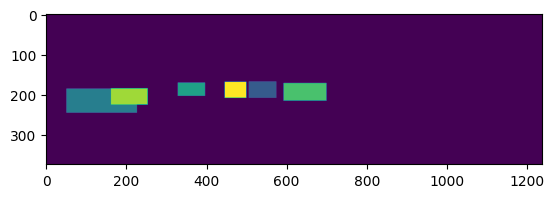

In [35]:
canvas = np.zeros(image.shape[:2], dtype=np.int8) - 1
for i, label in enumerate(labels):
    corners = label.generate_corners3d()
    uv, _ = calib_.rect_to_img(corners)
    u_min = round(max(0, np.min(uv[:, 0])))
    v_min = round(max(0, np.min(uv[:, 1])))
    u_max = round(min(np.max(uv[:, 0]), image.shape[1]))
    v_max = round(min(np.max(uv[:, 1]), image.shape[0]))
    
    canvas[v_min: v_max, u_min: u_max] = i
    label.area = (v_max - v_min) * (u_max - u_min)

from matplotlib import pyplot as plt
plt.imshow(canvas)
plt.show()

In [33]:
for i, label in enumerate(labels):
    area = np.sum(canvas == i)
    label.area = 1 - area / label.area

0.0
1.0
0.7537878787878788
1.0
1.0
1.0
1.0
